In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,InputLayer
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.preprocessing import MinMaxScaler


2024-07-19 17:38:49.220463: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 17:38:49.220620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 17:38:49.347742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df_train = pd.read_csv("/kaggle/input/practice/train_set.csv")
df_val = pd.read_csv("/kaggle/input/practice/val_set.csv")
df_test = pd.read_csv("/kaggle/input/practice/test_set.csv")

In [3]:
df_train.index = pd.to_datetime(df_train['date_time_IST'],format = '%d-%m-%Y %H:%M')
df_test.index = pd.to_datetime(df_test['date_time_IST'],format = '%d-%m-%Y %H:%M')
df_val.index = pd.to_datetime(df_val['date_time_IST'],format = '%d-%m-%Y %H:%M')

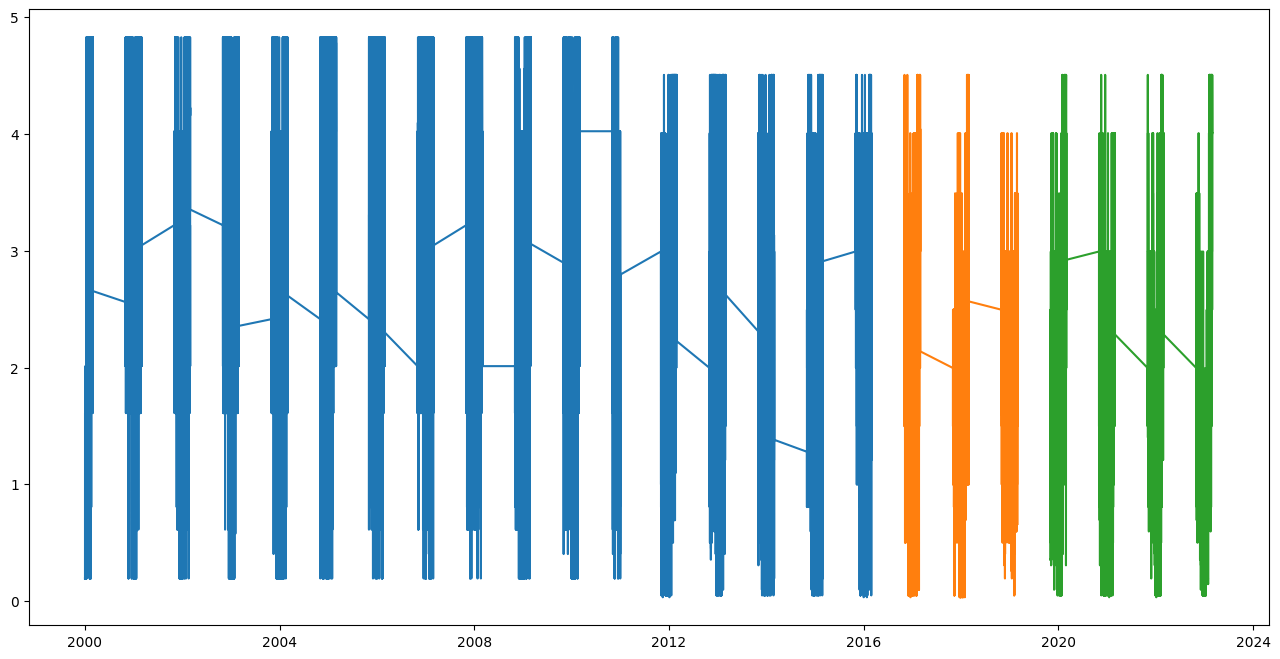

In [4]:
plt.figure(figsize=(16,8))
plt.plot(df_train['3hr_vsby_km'])
plt.plot(df_val['3hr_vsby_km'])
plt.plot(df_test['3hr_vsby_km'])


In [5]:
'''removing only the date_time_IST column and keeping everything else'''
df_train = df_train.drop(columns=['30min_fog', '1hr_fog', '1.5hr_fog', '2hr_fog',
       '2.5hr_fog', '3hr_fog', '6hr_fog', '30min_fog_type', '1hr_fog_type',
       '1.5hr_fog_type', '2hr_fog_type', '2.5hr_fog_type', '3hr_fog_type',
       '6hr_fog_type', '3hr_onset_cond','date_time_IST','30min_vsby_km', '1hr_vsby_km', '1.5hr_vsby_km',
       '2hr_vsby_km', '2.5hr_vsby_km', '6hr_vsby_km'])
df_test = df_test.drop(columns=['30min_fog', '1hr_fog', '1.5hr_fog', '2hr_fog',
       '2.5hr_fog', '3hr_fog', '6hr_fog', '30min_fog_type', '1hr_fog_type',
       '1.5hr_fog_type', '2hr_fog_type', '2.5hr_fog_type', '3hr_fog_type',
       '6hr_fog_type', '3hr_onset_cond','date_time_IST','30min_vsby_km', '1hr_vsby_km', '1.5hr_vsby_km',
       '2hr_vsby_km', '2.5hr_vsby_km', '6hr_vsby_km'])
df_val = df_val.drop(columns=['30min_fog', '1hr_fog', '1.5hr_fog', '2hr_fog',
       '2.5hr_fog', '3hr_fog', '6hr_fog', '30min_fog_type', '1hr_fog_type',
       '1.5hr_fog_type', '2hr_fog_type', '2.5hr_fog_type', '3hr_fog_type',
       '6hr_fog_type', '3hr_onset_cond','date_time_IST','30min_vsby_km', '1hr_vsby_km', '1.5hr_vsby_km',
       '2hr_vsby_km', '2.5hr_vsby_km', '6hr_vsby_km'])
# df_train = df_train.drop(columns=['date_time_IST'])
# df_test = df_test.drop(columns=['date_time_IST'])
# df_val = df_val.drop(columns=['date_time_IST'])

In [6]:
print(df_train.columns)
print(len(df_train.columns))

Index(['tmpc', 'dwpc', 'relh', 'drct', 'wspeedkm', 'pressure', 'vsbykm',
       'feelc', 'cos_min_time', 'sin_min_time', 'fog_time', 'fog_month',
       'diff_tempc_dwpc', '3hr_vsby_km'],
      dtype='object')
14


In [7]:
df_train.head()

,tmpc,dwpc,relh,drct,wspeedkm,pressure,vsbykm,feelc,cos_min_time,sin_min_time,fog_time,fog_month,diff_tempc_dwpc,3hr_vsby_km
date_time_IST,,,,,,,,,,,,,,
2000-01-01 00:00:00,10.0,10.0,100.0,0.0,0.0,101693.2917,0.193121,10.0,1.000000,0.000000,1,1,0.0,0.193121
2000-01-01 00:30:00,10.0,10.0,100.0,0.0,0.0,101693.2917,0.193121,10.0,0.991077,0.133287,1,1,0.0,0.193121
2000-01-01 01:00:00,10.0,10.0,100.0,0.0,0.0,101693.2917,0.193121,10.0,0.964469,0.264195,1,1,0.0,0.193121
2000-01-01 01:30:00,10.0,10.0,100.0,0.0,0.0,101667.8938,0.193121,10.0,0.920650,0.390389,1,1,0.0,0.193121
2000-01-01 02:30:00,10.0,10.0,100.0,0.0,0.0,101617.0979,0.193121,10.0,0.784799,0.619750,1,1,0.0,0.193121


In [8]:
#scaling the data
scaler = MinMaxScaler()
scaler.fit(df_train)
train_data_scaled = scaler.transform(df_train)
val_data_scaled = scaler.transform(df_val)
test_data_scaled = scaler.transform(df_test)

In [9]:
#preparing the data for lstm by sequencing
def df_to_X_y(df,window_size=48):
    df_as_np = df
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = df_as_np[i:i + window_size, :13]
        X.append(row)
        label = df_as_np[i+window_size][13]
        y.append(label)

    return np.array(X),np.array(y)
X_train,y_train = df_to_X_y(train_data_scaled)
X_val,y_val = df_to_X_y(val_data_scaled)
X_test,y_test=df_to_X_y(test_data_scaled)
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape


((78843, 48, 13),
 (78843,),
 (16340, 48, 13),
 (16340,),
 (22014, 48, 13),
 (22014,))

In [10]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((78843, 48, 13),
 (78843,),
 (16340, 48, 13),
 (16340,),
 (22014, 48, 13),
 (22014,))

In [25]:
model = Sequential()
model.add(InputLayer((48, 13)))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss=MeanSquaredError(),
    metrics=[RootMeanSquaredError(), MeanAbsoluteError(), MeanSquaredError()]
)


model.summary()
checkpoint_callback = ModelCheckpoint('best_model.keras',save_best_only = True,monitor = 'val_loss',mode = 'min')

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=64,
    callbacks=[checkpoint_callback, early_stopping_callback])

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 48, 128)        │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 48, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,561 (525.63 KB)

 Trainable params: 134,561 (525.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0420 - mean_absolute_error: 0.1468 - mean_squared_error: 0.0420 - root_mean_squared_error: 0.1951 - val_loss: 0.0104 - val_mean_absolute_error: 0.0789 - val_mean_squared_error: 0.0104 - val_root_mean_squared_error: 0.1018
Epoch 2/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0180 - mean_absolute_error: 0.1034 - mean_squared_error: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0122 - val_mean_absolute_error: 0.0849 - val_mean_squared_error: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 3/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - loss: 0.0172 - mean_absolute_error: 0.1005 - mean_squared_error: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0095 - val_mean_absolute_error: 0.0762 - val_mean_squared_error: 0.0095 - val_root_mean_squared_error: 0.0974
Epoch 4/30
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.0164 - mean_absolute_error: 0.0980 - mean_squared_error: 0.0164 - root

688/688 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


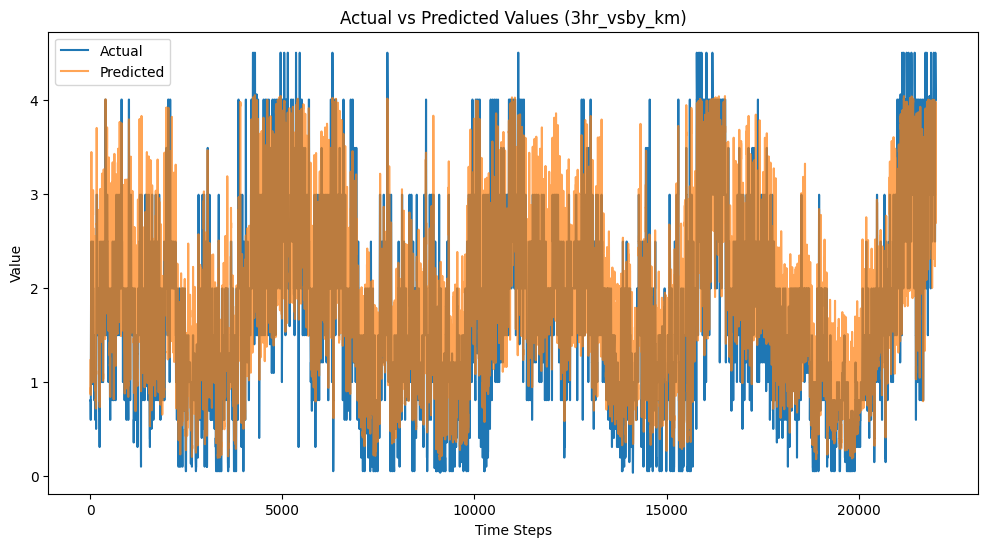

test-rmse:  0.46798977180572293
test-mae: 0.3655143336876434
test-r2_score:  0.772831523614977


In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

scalervsby = MinMaxScaler()
scalervsby.fit(df_train.iloc[:, 13].values.reshape(-1, 1))

# Perform predictions and inverse transformations
predictions = model.predict(X_test)
predictions_inverse = scalervsby.inverse_transform(predictions)

y_test_6th_column = y_test.reshape(-1, 1)  # Reshape to (n_samples, 1)
y_test_inverse = scalervsby.inverse_transform(y_test_6th_column)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_inverse, label='Actual')
plt.plot(predictions_inverse, label='Predicted',alpha = 0.7)
plt.title('Actual vs Predicted Values (3hr_vsby_km)')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
rmse = np.sqrt(mean_squared_error(y_test_inverse,predictions_inverse))
mae = mean_absolute_error(y_test_inverse,predictions_inverse)
r2 = r2_score(y_test_inverse,predictions_inverse)
print("test-rmse: ",rmse)
print('test-mae:',mae)
print('test-r2_score: ',r2)

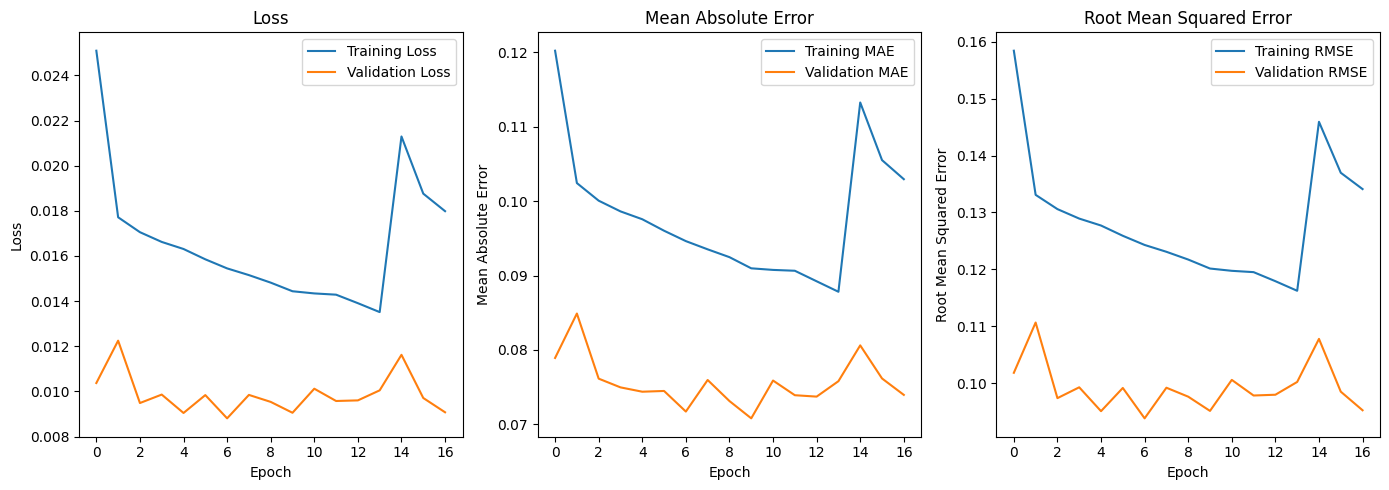

In [27]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable where the training history is stored
history_dict = history.history

# Plot training & validation loss values
plt.figure(figsize=(14, 5))

# Loss
plt.subplot(1 ,3, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Mean Absolute Error
if 'mean_absolute_error' in history_dict:
    plt.subplot(1, 3, 2)
    plt.plot(history_dict['mean_absolute_error'], label='Training MAE')
    plt.plot(history_dict['val_mean_absolute_error'], label='Validation MAE')
    plt.title('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()


# Root Mean Squared Error
if 'root_mean_squared_error' in history_dict:
    plt.subplot(1, 3, 3)
    plt.plot(history_dict['root_mean_squared_error'], label='Training RMSE')
    plt.plot(history_dict['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('Root Mean Squared Error')
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error')
    plt.legend()

plt.tight_layout()
plt.show()
